* 以2010-01-01 年至2018-12-31 之 S&P 500 指數的日資料(daily data) 為研究對象。以當日及過去30 日之每日(Open, High, Low, Close, Volume) 為特徵(features), 預測10 日後之Close。
* 訓練樣本(train set) 與測試樣本(test set) 比為8:2。 
* 以訓練樣本建立預測模型。特徵預處理(preprocessing) 方法考慮sklearn 之MinMaxScaler 和StandardScaler。
* 配合sklearn 之Pipeline, GridSearchCV 作法, 決定模型最佳超參數(hyperparameter(s)), 亦即做下列模型之參數調整(tune parameters)。交叉驗證(cross-validation) 方法取為sklearn 之KFold, scoring 取為'neg mean absolute error'。
* 決定最佳超參數準則為：盡可能避免overtting 及希望交叉驗證(cross-validation) 時可考慮mean test score 和std test score, 其中score 為'neg mean absolute error'。

# Package

In [1]:
import numpy as np 
import pandas as pd
import pandas_datareader as web
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline, Pipeline
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Dataset

In [2]:
ticker = '^GSPC'
start = '2009-01-01'
end = '2018-12-31'
df = web.data.DataReader(ticker, 'yahoo', start, end)
df = df.drop(['Adj Close'], axis=1)

In [3]:
df.head(5)

,High,Low,Open,Close,Volume
Date,,,,,
2008-12-31,910.320007,889.669983,890.590027,903.250000,4172940000
2009-01-02,934.729980,899.349976,902.989990,931.799988,4048270000
2009-01-05,936.630005,919.530029,929.169983,927.450012,5413910000
2009-01-06,943.849976,927.280029,931.169983,934.700012,5392620000
2009-01-07,927.450012,902.369995,927.450012,906.650024,4704940000


In [4]:
df.shape

(2517, 5)

# Feature Engineering

### Adding Target: 
'close_next10' : close after 10 days

In [6]:
target = 'Close'
shift = -10
target_next = target+'_next'+str(-shift)
target_next_pred = target_next+'_pred'
df[target_next] = df[target].shift(shift)
df = df.dropna()

### Adding Features:  
'Close_PctChange': (close2 - close1) / close1  
'High_Close_Change': (high1 - close1 ) / close1  
'Close_Open_Change': (close1 - open1) / open1  
lag 1~30 days for each feature

In [7]:
target_PctChange = target+'_PctChange'
df[target_PctChange] = df[target].pct_change()

In [8]:
df['High_Close_Change'] = (df['High']-df['Close'])/df['Close']
df['Close_Open_Change'] = (df['Close']-df['Open'])/df['Open']

In [9]:
features = list(df.columns[~df.columns.isin([target_next])])
lag = 30
for i in range(1,lag+1):
    for feature in features:
        df[feature+"_lag"+str(i)] = df[feature].shift(i)
    
df = df.dropna()

# Preprocessing

In [10]:
X = df.drop([target_next], axis=1)
y = df[target_next]

In [11]:
train_size = 0.8
N = X.shape[0]
Num_train = int(N*train_size)

X_train, y_train = X[:Num_train], y[:Num_train]
X_test, y_test = X[Num_train:], y[Num_train:]

# Hypetuning

* (a) 以sklearn 之Ridge (ridge regression) 為例, 超參數alpha 考慮0.1, 0.01, 0.001, 共3 種情況
* (b) 以sklearn 之MLPRegressor (類神經網絡之多層感知機(MultiLayer Perceptron, MLP)) 為例, 超參數alpha 考慮0.1, 0.01, 0.001, 共3 種情況。hidden layer sizes 考慮: 一個hidden layer 的sizes 為64 二個hidden layer的sizes 為64 共4 種情況
* 以Pipeline方式同時考慮(a)、(b)
* 模型的random state為123457
* 交叉驗證的random state為123457
* 交叉驗證的scoring為neg_mean_absolute_error
* kfold切3等分

### 交叉驗證最適參數的選擇為 mean_test_score + 1.96 * std_test_score 最大者。原因在於除了考慮整體平均表現外，還需考慮參數對於模型的穩定性。

In [12]:
pipeline1 = ('scaler', MinMaxScaler())
pipeline2 = ('regressor', Ridge())
pipeline = Pipeline([pipeline1, pipeline2])

pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'scaler', 'regressor', 'scaler__copy', 'scaler__feature_range', 'regressor__alpha', 'regressor__copy_X', 'regressor__fit_intercept', 'regressor__max_iter', 'regressor__normalize', 'regressor__random_state', 'regressor__solver', 'regressor__tol'])

In [13]:
random_state = 123457

In [14]:
scaler = [None, MinMaxScaler(), StandardScaler()]

In [15]:
param_grid1 = {'scaler': scaler,
               'regressor': [Ridge(random_state=random_state)],
               'regressor__alpha': [0.1, 0.01],
               }

param_grid2 = {'scaler': scaler,
               'regressor': [MLPRegressor(random_state=random_state)],
               'regressor__hidden_layer_sizes': [(64), (64, 64)],
               'regressor__activation': ['relu'],
               'regressor__solver': ['lbfgs'],
               'regressor__alpha': [0.1, 0.01],
               #'regressor__batch_size': ['auto'], 
               #'regressor__learning_rate': ['constant'],
               #'regressor__learning_rate_init': [0.01, 0.001],
               #'regressor__max_iter': [200]
               }

param_grid = [param_grid1, param_grid2]

In [16]:
scoring = 'neg_mean_absolute_error'

In [17]:
n_splits = 3
random_state = 123457
cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)  
SearchCV = GridSearchCV(estimator=pipeline, 
                        param_grid=param_grid,
                        scoring=scoring, 
                        cv=cv,
                        return_train_score=True,
                        verbose=1,
                        n_jobs=-1)

In [18]:
SearchCV.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  1.9min finished
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


GridSearchCV(cv=KFold(n_splits=3, random_state=123457, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('regressor', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'scaler': [None, MinMaxScaler(copy=True, feature_range=(0, 1)), StandardScaler(copy=True, with_mean=True, with_std=True)], 'regressor': [Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=123457, solver='auto', tol=0.001)], 'regressor__alph...'regressor__activation': ['relu'], 'regressor__solver': ['lbfgs'], 'regressor__alpha': [0.1, 0.01]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [21]:
cv_results = SearchCV.cv_results_
cv_results_df = pd.DataFrame(cv_results)
sorted(cv_results.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_regressor',
 'param_regressor__activation',
 'param_regressor__alpha',
 'param_regressor__hidden_layer_sizes',
 'param_regressor__solver',
 'param_scaler',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [22]:
cv_results_df['upper_train_score'] = \
    -cv_results_df['mean_train_score']+1.96*cv_results_df['std_train_score']
cv_results_df['upper_test_score'] = \
    -cv_results_df['mean_test_score']+1.96*cv_results_df['std_test_score']

In [23]:
upper_test_score_min = cv_results_df['upper_test_score'].min()
best_params = cv_results_df[cv_results_df['upper_test_score'] == upper_test_score_min]
best_params

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor,param_regressor__alpha,param_scaler,param_regressor__activation,param_regressor__hidden_layer_sizes,param_regressor__solver,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,upper_train_score,upper_test_score
16,7.05307,0.272409,0.017334,0.001247,"MLPRegressor(activation='relu', alpha=0.01, ba...",0.01,"MinMaxScaler(copy=True, feature_range=(0, 1))",relu,"(64, 64)",lbfgs,...,-32.112306,0.821257,1,-30.455678,-29.089632,-30.340433,-29.961914,0.618588,31.174348,33.72197


# Modeling

In [24]:
best_params_scaler = best_params['param_scaler'].values[0]
best_params_regressor = best_params['params'].values[0]['regressor']
best_scaler = ('scaler', best_params_scaler)
best_regressor = ('regressor', best_params_regressor)
best_estimator = Pipeline([best_scaler, best_regressor])

In [26]:
best_estimator.fit(X_train, y_train)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('regressor', MLPRegressor(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(64, 64), learning_rate='constant',
       learning_rate_init...True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])

In [27]:
y_train_pred = best_estimator.predict(X_train)
y_test_pred = best_estimator.predict(X_test)

# Validation

In [28]:
import sklearn.metrics as metrics


MAE_train = metrics.mean_absolute_error(y_train, y_train_pred)
MAE_test = metrics.mean_absolute_error(y_test, y_test_pred)
print("train MAE (mean_absolute_error):", MAE_train)
print("test MAE (mean_absolute_error):", MAE_test)

test_score = best_estimator.score(X_test, y_test)
print("test score (r2):", test_score)

train MAE (mean_absolute_error): 30.65510286860393
test MAE (mean_absolute_error): 47.84897545782607
test score (r2): 0.8583839233909528


In [47]:
import matplotlib.pyplot as plt


def plot_target_pred(y, y_pred, target_next):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4.5))
    target_next_pred = target_next+'_pred'
    ax1.plot(y, 'b-', label=target_next)
    ax1.plot(y_pred, 'r-.', label=target_next_pred)
    ax1.legend()
    target_next_pred = target_next+'_pred'
    ax2.plot(y, y_pred, '.')
    ax2.set_xlabel(target_next)
    ax2.set_ylabel(target_next_pred)
    ax2.legend()
    plt.tight_layout()
    plt.show() 

No handles with labels found to put in legend.


Traing Data:


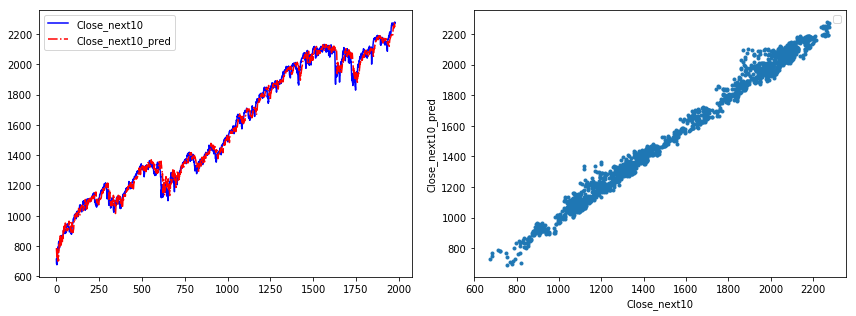

In [48]:
print('Traing Data:')    
plot_target_pred(y_train.values, y_train_pred, target_next)

No handles with labels found to put in legend.


Test Data:


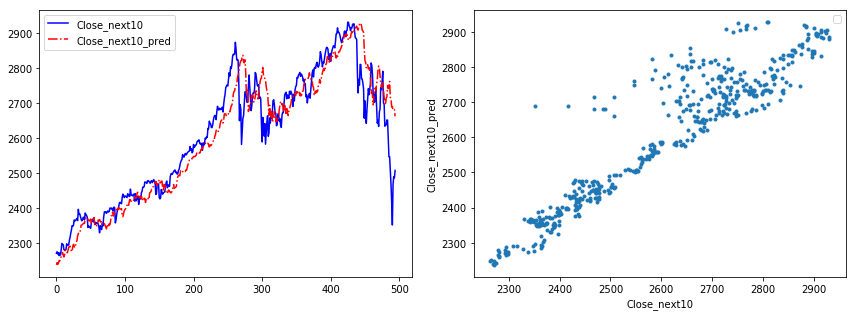

In [49]:
print('Test Data:')
plot_target_pred(y_test.values, y_test_pred, target_next)